# Full video diarization script

This script diarizes the full videos 175-185. Create the `./embeds` directory in this folder, it is not included by default. The outputs of this notebook relate to the third full diarization run in `trecvid_diarization_third.tar`.

In [1]:
import os
import numpy as np
import wavefile
from SphereDiar.embed import VLAD, amsoftmax_loss
from SphereDiar.meeting_corpus_util import *
from SphereDiar.SphereDiar import *
from librosa.util import frame
from librosa.feature import mfcc
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from keras.models import load_model
import warnings
#warnings.filterwarnings("ignore", message="Numerical issues were encountered ")

Using TensorFlow backend.
/l/virkkua1/anaconda3/envs/sphere/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


Replaced StandardScaler with MinMaxScales because the StandardScaler produces hundreds of warnings about numerical issues. With MinMax there are no numeric issues.

In [2]:
def fe(s, fs = 16000):
    mfcc_feat = mfcc(s, n_mfcc = 30, sr = fs, n_fft=512, hop_length=160)  
    return MinMaxScaler().fit_transform(mfcc_feat)
    #return scale(mfcc_feat, axis=1)

Check that you have the `./embeds` and `./data` folders and the model.

In [3]:
emb_path = "./embeds"
data_path = "./data"
model_path = "./SphereDiar/models/current_best.h5"
emb_model = load_model(model_path, custom_objects={'VLAD': VLAD, 'amsoftmax_loss': amsoftmax_loss})
SD = SphereDiar(emb_model)





Instructions for updating:
dim is deprecated, use axis instead








/l/virkkua1/anaconda3/envs/sphere/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
wavs = [f.name for f in os.scandir(data_path) if f.name.endswith(".wav")]
wavs.sort()
true_speaker_counts = [29, 41, 36, 27, 36, 36, 31, 28, 34, 54, 54]
wavs = list(zip(wavs, true_speaker_counts))

In [5]:
speaker_counts = []
for wavfile, spks in wavs:
    (rate, sig) = wavefile.load(f"{data_path}/{wavfile}")
    signal = sig[0]
    S = np.transpose(frame(signal, int(2000*16), int(500*16)))
    X = list(map(lambda s: fe(s, 16000), S))
    X = np.array(np.swapaxes(X, 1, 2))
    X = X.astype(np.float16)
    num_timesteps = X.shape[1]
    
    if num_timesteps != 201:
        emb_model.layers.pop(0)
        new_input = Input(batch_shape=(None, num_timesteps, 30))
        new_output = emb_model(new_input)
        emb_model = Model(new_input, new_output)
        
    embs = emb_model.predict(X)
    
    SD.cluster(rounds=10, clust_range=[spks-10, spks], num_cores = -2, embeddings=embs)
    spk_labels = SD.speaker_labels_
    speakers = np.unique(spk_labels)
    speaker_counts.append(speakers)
    print(len(speakers))
    np.save(f"{emb_path}/{wavfile[:3]}_embeds", embs)
    np.save(f"{emb_path}/{wavfile[:3]}_speaker_labels", spk_labels)
    np.savetxt(f"{emb_path}/{wavfile[:3]}_speaker_labels.txt", spk_labels)

Clustering round:  0
Clustering round:  1
Clustering round:  2
Clustering round:  3
Clustering round:  4
Clustering round:  5
Clustering round:  6
Clustering round:  7
Clustering round:  8
Clustering round:  9
Inner clustering round:  0
20
Clustering round:  0
Clustering round:  1
Clustering round:  2
Clustering round:  3
Clustering round:  4
Clustering round:  5
Clustering round:  6
Clustering round:  7
Clustering round:  8
Clustering round:  9
Inner clustering round:  0
32
Clustering round:  0
Clustering round:  1
Clustering round:  2
Clustering round:  3
Clustering round:  4
Clustering round:  5
Clustering round:  6
Clustering round:  7
Clustering round:  8
Clustering round:  9
Inner clustering round:  0
27
Clustering round:  0
Clustering round:  1
Clustering round:  2
Clustering round:  3
Clustering round:  4
Clustering round:  5
Clustering round:  6
Clustering round:  7
Clustering round:  8
Clustering round:  9
Inner clustering round:  0
18
Clustering round:  0
Clustering round:  

In [6]:
print(speaker_counts)

[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=int32), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype=int32), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27], dtype=int32), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18], dtype=int32), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27], dtype=int32), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22], dtype=int32), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19],

In [7]:
embs.shape

(10474, 700)

Computing TSNE transform...


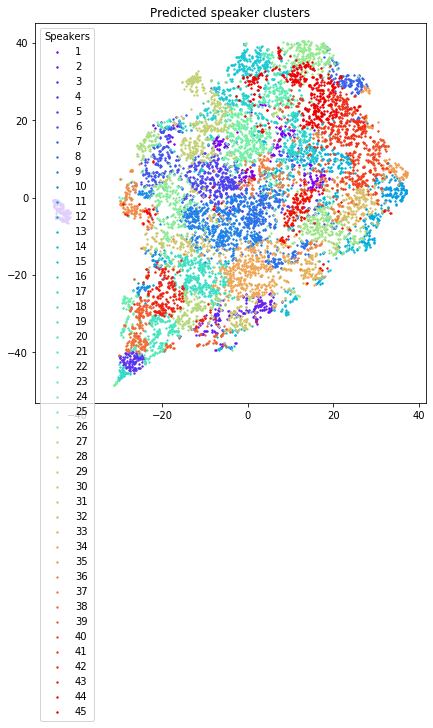

In [8]:
SD.visualize()